In [12]:
import autograd.numpy as np
from autograd import grad
import nlopt, numpy as npf
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import use_autograd
use_autograd.use = 1
import rcwa
from utils import test_grad

In [22]:
t = 59e-9
Period = 2e-6

c0 = 299792458
rho = 2.329e3
mp = 1e-4;
I = 1e10;
A = 10
vf = 0.2*c0
lam0 = 1.2e-6

N = 20
v = np.linspace(0,vf,N)
freq_list = np.sqrt((c0-v)/(c0+v))
gamma = 1./np.sqrt(1-(v/c0)**2)

Nx = 50
Ny = 50

In [23]:
nG = 101
# lattice vector
Lx = Period/lam0
Ly = Period/lam0
L1 = [Lx,0.]
L2 = [0.,Ly]

# planewave excitation
p_amp = 0.
s_amp = 1.
p_phase = 0.
s_phase = 0.
# frequency and angles
theta = 0.
phi = 0.

# now consider three layers: vacuum + patterned + vacuum
epsuniform1 = 1.
epsdiff = 11.3
epsbkg = 1
epsuniform3 = 1.

thick1 = 1.
thick2 = t/lam0
thick3 = 1.

In [24]:
ctrl = 0
def fun_Distance(dof):
    mT = mp + t*A*rho*np.mean(dof)

    R = np.array([])
    for freq in freq_list:
        obj = rcwa.RCWA_obj(nG,L1,L2,freq,theta,phi,verbose=0)
        obj.Add_LayerUniform(thick1,epsuniform1)
        obj.Add_LayerGrid(thick2,epsdiff,epsbkg,Nx,Ny)
        obj.Add_LayerUniform(thick3,epsuniform3)
        obj.Init_Setup(Gmethod=0)

        obj.MakeExcitationPlanewave(p_amp,p_phase,s_amp,s_phase,order = 0)
        obj.GridLayer_getDOF(dof)
        Rtmp,_ = obj.RT_Solve()

        R = np.append(R,Rtmp)

    integrand = mT/R*gamma*v/(1-v/c0)**2
    #D = c0/2/I/A*np.trapz(integrand,x=v)/1e9
    D = c0/2/I/A*(np.sum(integrand)-integrand[0]/2-integrand[-1]/2)*(v[1]-v[0])/1e9

    if 'autograd' not in str(type(D)):
        global ctrl
        
        print ctrl,np.mean(R),D
        if npf.mod(ctrl,5)==0:
            plt.figure();
            plt.imshow(np.reshape(dof,(Nx,Ny)))
            plt.colorbar()
            plt.show()
            
        ctrl +=1
    return D

0 0.6406223553339963 8.582405248385149


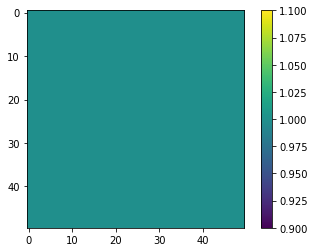

1 0.6405239575100156 8.58175852040518
2 0.639547158956928 8.575372883970132
3 0.6265322471015319 8.496095157781843
4 0.5132082591994166 8.180951957060278
5 0.3608238456777203 8.654915961701692


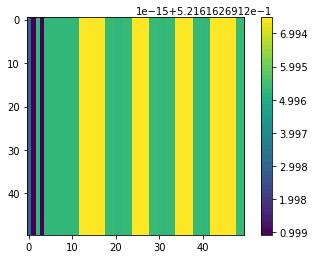

6 0.49146953989049774 8.186118053763126
7 0.5086729972374692 8.180406394653678
8 0.5007134618037329 8.181520684643978
9 0.5078663049812165 8.180399247753959
10 0.5080405364141868 8.180398495261702


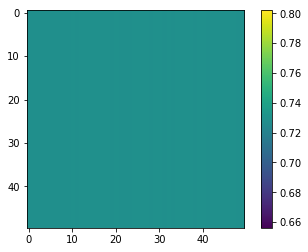

11 0.5082577829471898 8.180399328952724
12 0.5080622779116851 8.180398490131193
13 0.5080575448628133 8.180398489570834
14 0.5080554308792334 8.180398489622124
15 0.5080571192416543 8.180398489566182


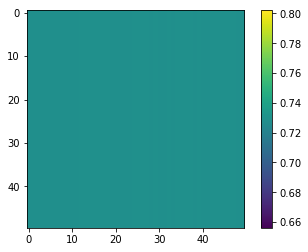

In [25]:
grad_fun = grad(fun_Distance)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun_Distance(dof)

ndof = Nx*Ny
init = np.ones(ndof)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)